In [1]:
import ta
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
warnings.filterwarnings("ignore")

plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'black'

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

In [6]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

In [7]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float, INITIAL_MARGIN: float) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares

    # Add short positions equity (margin_account + margin_requirement - cost to cover)
    for pos in short_ops:
        cover_cost = current_price * pos.n_shares * (1 + COM)  # include commission
        margin_requirement = pos.price * pos.n_shares * INITIAL_MARGIN
        proceeds = pos.price * pos.n_shares - cover_cost
        val +=  proceeds + margin_requirement - cover_cost

    return val

In [8]:
data = pd.read_csv('Data/aapl_5m_train.csv').dropna()

## <font color='cornflowerblue'> Optimización de hiperparámetros

In [9]:
def backtest(data, trial) -> float:
    data = data.copy()

    # Hyperparameters to optimize
    rsi_window = trial.suggest_int('rsi_window', 5, 50)
    rsi_lower = trial.suggest_int('rsi_lower', 5, 35)
    rsi_upper = trial.suggest_int('rsi_upper', 65, 95)
    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trial.suggest_int('n_shares', 50, 500)

    # Indicators
    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indicator.rsi()

    # Signals
    data['buy_signal'] = data.rsi < rsi_lower
    data['sell_signal'] = data.rsi > rsi_upper

    # Initial values
    capital: float = 1_000_000
    margin_account: float = 0
    portfolio_value = [capital]
    active_long_positions: list[Position] = []
    active_short_positions: list[Position] = []

    # Commissions and rates
    COM: float = 0.125 / 100
    BORROW_RATE: float = 0.25 / 100
    INITIAL_MARGIN = 0.5
    MAINTENANCE_MARGIN = 0.25

    # Convert annualized borrow rate to 5-min bar rate
    bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
    bar_borrow_rate = (1 + BORROW_RATE) ** (1 / bars_per_year) - 1

    # Strategy parameters
    STOP_LOSS: float = stop_loss
    TAKE_PROFIT: float = take_profit
    N_SHARES: int = n_shares

    for i, row in data.iterrows():
        # -- LONG -- #
        # Check active orders
        for position in active_long_positions.copy():
            # Stop loss or take profit check
            if row.Close > position.tp or row.Close < position.sl:
                # Add profits / losses to capital
                capital += row.Close * position.n_shares * (1 - COM)
                # Remove position from active position
                active_long_positions.remove(position)

        equity: float = 0.0
        required_equity: float = 0.0

        # -- SHORT -- #
        for position in active_short_positions.copy():
            # Apply borrow rate to active short positions
            cover_cost = row.Close * position.n_shares * (1 + COM)
            capital -= row.Close * position.n_shares * bar_borrow_rate
            equity += position.price * position.n_shares * (1 - COM) - cover_cost + position.price * position.n_shares * INITIAL_MARGIN

            # Required Equity
            required_equity += MAINTENANCE_MARGIN * cover_cost
            
        for position in active_short_positions.copy():
            cover_cost = row.Close * position.n_shares * (1 + COM)
            # Check Margin call
            if equity < required_equity:
                # Margin Call
                deposit = required_equity - equity
                print(f'Margin Call at {row.Datetime} | Equity: {equity:.2f} | Required: {required_equity:.2f}')

                if capital > deposit:
                    capital -= deposit
                    equity += deposit
                    
                else:
                    # We have to close the position
                    capital += position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                    margin_account -= position.price * N_SHARES * (1 - COM)
                    active_short_positions.remove(position)
                    #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                    #required_equity -= MAINTENANCE_MARGIN * cover_cost
                    continue

            else:
                # Stop loss or take profit check
                if row.Close < position.tp or row.Close > position.sl:
                    # Add profits / losses to capital
                    capital += position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                    margin_account -= position.price * N_SHARES * (1 - COM)
                    active_short_positions.remove(position)
                    #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                    #required_equity -= MAINTENANCE_MARGIN * cover_cost
                    continue

        # Check Long Signal
        if getattr(row, "buy_signal", False):
            cost = row.Close * N_SHARES * (1 + COM)

            # Do we have enough cash?
            if capital > cost:
                # Discount cash
                capital -= cost
                # Add position to portfolio
                pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                            sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                            time=row.Datetime)
                active_long_positions.append(pos)

        # Check Short Signal
        if getattr(row, "sell_signal", False):
            margin_requirement = row.Close * N_SHARES * INITIAL_MARGIN
            
            # Do we have enough cash?
            if capital > margin_requirement:
                # Setting up the margin account
                margin_account += row.Close * N_SHARES * (1 - COM)
                # Discount cash
                capital -= margin_requirement

                pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                            sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                            time=row.Datetime)
                active_short_positions.append(pos)

        # Calculate portfolio value
        portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM, INITIAL_MARGIN))
        continue
    # At the end of the backtesting, we should close all active positions
    capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

    for position in active_short_positions:
        capital += position.price * N_SHARES * INITIAL_MARGIN - row.Close * N_SHARES * (1 + COM) + position.price * N_SHARES * (1 - COM)
        margin_account -= position.price * N_SHARES * (1 - COM)
        #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
        #required_equity -= MAINTENANCE_MARGIN * cover_cost

    active_long_positions = []
    active_short_positions = []

    return (capital / 1_000_000) - 1

In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: backtest(data, trial), n_trials=10, n_jobs=-1)

[I 2025-09-21 19:51:31,029] A new study created in memory with name: no-name-bf51dfcb-a437-4287-8ee7-bee14905e880
[I 2025-09-21 19:51:37,882] Trial 0 finished with value: -0.028326261884042414 and parameters: {'rsi_window': 38, 'rsi_lower': 30, 'rsi_upper': 85, 'stop_loss': 0.1382761836539083, 'take_profit': 0.014842142864038652, 'n_shares': 341}. Best is trial 0 with value: -0.028326261884042414.
[I 2025-09-21 19:51:38,893] Trial 2 finished with value: -0.07279805290299579 and parameters: {'rsi_window': 27, 'rsi_lower': 30, 'rsi_upper': 84, 'stop_loss': 0.060987503607961284, 'take_profit': 0.010835989647249317, 'n_shares': 265}. Best is trial 0 with value: -0.028326261884042414.
[I 2025-09-21 19:51:42,008] Trial 4 finished with value: 0.06326995821569703 and parameters: {'rsi_window': 43, 'rsi_lower': 28, 'rsi_upper': 70, 'stop_loss': 0.08179301122720038, 'take_profit': 0.023840922248562, 'n_shares': 151}. Best is trial 4 with value: 0.06326995821569703.
[I 2025-09-21 19:51:47,049] Tr

## <font color='cornflowerblue'> Resultados

In [11]:
study.best_params

{'rsi_window': 45,
 'rsi_lower': 5,
 'rsi_upper': 67,
 'stop_loss': 0.0920235082102392,
 'take_profit': 0.10704664973145434,
 'n_shares': 306}

In [12]:
study.best_value

0.26149220265643636

## <font color='cornflowerblue'> Uso de resultados óptimos

In [15]:
# Windows
window = study.best_params['rsi_window']
lower = study.best_params['rsi_lower']
upper = study.best_params['rsi_upper']

# Commissions and rates
COM = 0.125 / 100
BORROW_RATE = 0.25 / 100
INITIAL_MARGIN = 0.5
MAINTENANCE_MARGIN = 0.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = (1 + BORROW_RATE) ** (1 / bars_per_year) - 1

# Strategy parameters
STOP_LOSS: float = study.best_params['stop_loss']
TAKE_PROFIT: float = study.best_params['take_profit']
N_SHARES: int = study.best_params['n_shares']

In [16]:
# Data
data = pd.read_csv('Data/aapl_5m_train.csv').dropna()

# Indicators
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=window)
data['rsi'] = rsi_indicator.rsi()

# Signals
data['buy_signal'] = data['rsi'] < lower
data['sell_signal'] = data['rsi'] > upper

## <font color='cornflowerblue'> Backtest

In [17]:
capital: float = 1_000_000
margin_account: float = 0.0

portfolio_value = [capital]
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []

for i, row in data.iterrows():
    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active position
            active_long_positions.remove(position)

    equity: float = 0.0
    required_equity: float = 0.0

    # -- SHORT -- #
    for position in active_short_positions.copy():
        # Apply borrow rate to active short positions
        cover_cost = row.Close * position.n_shares * (1 + COM)
        capital -= row.Close * position.n_shares * bar_borrow_rate
        equity += position.price * position.n_shares * (1 - COM) - cover_cost + position.price * position.n_shares * INITIAL_MARGIN

        # Required Equity
        required_equity += MAINTENANCE_MARGIN * cover_cost
        
    for position in active_short_positions.copy():
        cover_cost = row.Close * position.n_shares * (1 + COM)
        # Check Margin call
        if equity < required_equity:
            # Margin Call
            deposit = required_equity - equity
            print(f'Margin Call at {row.Datetime} | Equity: {equity:.2f} | Required: {required_equity:.2f}')

            if capital > deposit:
                capital -= deposit
                equity += deposit
                
            else:
                # We have to close the position
                capital += position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                margin_account -= position.price * N_SHARES * (1 - COM)
                active_short_positions.remove(position)
                #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                #required_equity -= MAINTENANCE_MARGIN * cover_cost
                continue

        else:
            # Stop loss or take profit check
            if row.Close < position.tp or row.Close > position.sl:
                # Add profits / losses to capital
                capital += position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                margin_account -= position.price * N_SHARES * (1 - COM)
                active_short_positions.remove(position)
                #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
                #required_equity -= MAINTENANCE_MARGIN * cover_cost
                continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           time=row.Datetime)
            active_long_positions.append(pos)

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        margin_requirement = row.Close * N_SHARES * INITIAL_MARGIN
        
        # Do we have enough cash?
        if capital > margin_requirement:
            # Setting up the margin account
            margin_account += row.Close * N_SHARES * (1 - COM)
            # Discount cash
            capital -= margin_requirement

            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                           time=row.Datetime)
            active_short_positions.append(pos)

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM, INITIAL_MARGIN))
    continue
# At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

for position in active_short_positions:
    capital += position.price * N_SHARES * INITIAL_MARGIN - row.Close * N_SHARES * (1 + COM) + position.price * N_SHARES * (1 - COM)
    margin_account -= position.price * N_SHARES * (1 - COM)
    #equity -= position.price * N_SHARES * INITIAL_MARGIN - cover_cost + position.price * N_SHARES * (1 - COM)
    #required_equity -= MAINTENANCE_MARGIN * cover_cost

active_long_positions = []
active_short_positions = []

## <font color='cornflowerblue'> Plots

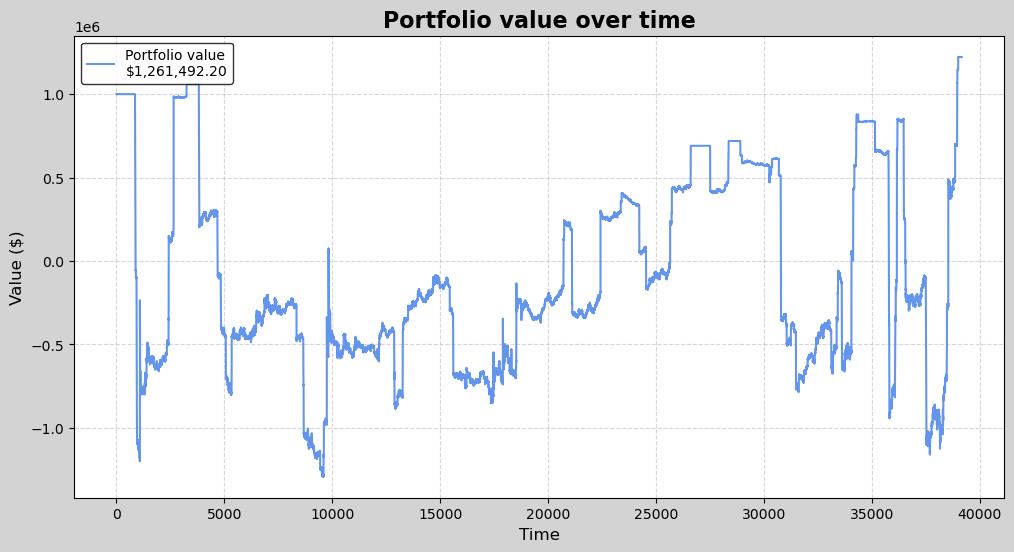

In [20]:
plt.figure()
plt.plot(portfolio_value, color=colors[0], label=f'Portfolio value\n${capital:,.2f}')
plt.title('Portfolio value over time')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.show()